<a href="https://colab.research.google.com/github/Suraba03/ml_san_francisco_permits/blob/main/san_fancisco.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# import data and first glance

In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

In [ ]:
!ls

drive  sample_data


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/san_francisco/Building_Permits.csv')

<ipython-input-3-5a9255161ba3>:1: DtypeWarning: Columns (22,32) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/san_francisco/Building_Permits.csv')


In [ ]:
pd.set_option('display.max_columns', None)

In [ ]:
df.head()

,Permit Number,Permit Type,Permit Type Definition,Permit Creation Date,Block,Lot,Street Number,Street Number Suffix,Street Name,Street Suffix,Unit,Unit Suffix,Description,Current Status,Current Status Date,Filed Date,Issued Date,Completed Date,First Construction Document Date,Structural Notification,Number of Existing Stories,Number of Proposed Stories,Voluntary Soft-Story Retrofit,Fire Only Permit,Permit Expiration Date,Estimated Cost,Revised Cost,Existing Use,Existing Units,Proposed Use,Proposed Units,Plansets,TIDF Compliance,Existing Construction Type,Existing Construction Type Description,Proposed Construction Type,Proposed Construction Type Description,Site Permit,Supervisor District,Neighborhoods - Analysis Boundaries,Zipcode,Location,Record ID
0,201505065519,4,sign - erect,05/06/2015,0326,023,140,NaN,Ellis,St,NaN,NaN,"ground fl facade: to erect illuminated, electr...",expired,12/21/2017,05/06/2015,11/09/2015,NaN,11/09/2015,NaN,6.0,NaN,NaN,NaN,11/03/2016,4000.0,4000.0,tourist hotel/motel,143.0,NaN,NaN,2.0,NaN,3.0,constr type 3,NaN,NaN,NaN,3.0,Tenderloin,94102.0,"(37.785719256680785, -122.40852313194863)",1380611233945
1,201604195146,4,sign - erect,04/19/2016,0306,007,440,NaN,Geary,St,0.0,NaN,remove (e) awning and associated signs.,issued,08/03/2017,04/19/2016,08/03/2017,NaN,08/03/2017,NaN,7.0,NaN,NaN,NaN,12/03/2017,1.0,500.0,tourist hotel/motel,NaN,NaN,NaN,2.0,NaN,3.0,constr type 3,NaN,NaN,NaN,3.0,Tenderloin,94102.0,"(37.78733980600732, -122.41063199757738)",1420164406718
2,201605278609,3,additions alterations or repairs,05/27/2016,0595,203,1647,NaN,Pacific,Av,NaN,NaN,installation of separating wall,withdrawn,09/26/2017,05/27/2016,NaN,NaN,NaN,NaN,6.0,6.0,NaN,NaN,NaN,20000.0,NaN,retail sales,39.0,retail sales,39.0,2.0,NaN,1.0,constr type 1,1.0,constr type 1,NaN,3.0,Russian Hill,94109.0,"(37.7946573324287, -122.42232562979227)",1424856504716
3,201611072166,8,otc alterations permit,11/07/2016,0156,011,1230,NaN,Pacific,Av,0.0,NaN,repair dryrot & stucco at front of bldg.,complete,07/24/2017,11/07/2016,07/18/2017,07/24/2017,07/18/2017,NaN,2.0,2.0,NaN,NaN,07/13/2018,2000.0,2000.0,1 family dwelling,1.0,1 family dwelling,1.0,2.0,NaN,5.0,wood frame (5),5.0,wood frame (5),NaN,3.0,Nob Hill,94109.0,"(37.79595867909168, -122.41557405519474)",1443574295566
4,201611283529,6,demolitions,11/28/2016,0342,001,950,NaN,Market,St,NaN,NaN,demolish retail/office/commercial 3-story buil...,issued,12/01/2017,11/28/2016,12/01/2017,NaN,11/20/2017,NaN,3.0,NaN,NaN,NaN,12/01/2018,100000.0,100000.0,retail sales,NaN,NaN,NaN,2.0,NaN,3.0,constr type 3,NaN,NaN,NaN,6.0,Tenderloin,94102.0,"(37.78315261897309, -122.40950883997789)",144548169992


In [ ]:
df.shape

(198900, 43)

# preprocessing

let's remove white spaces from columns names

In [ ]:
df = df.rename(lambda name: name.replace(" ", ""), axis='columns')

let's divide features list into two groups: numerical and categorical

In [ ]:
num_cols = [col for col in df.columns if "int" in str(df[col].dtype) or "float" in str(df[col].dtype)]
cat_cols = [col for col in df.columns if "object" == str(df[col].dtype) and col != "CurrentStatus"]
print(num_cols)
print(cat_cols)

['PermitType', 'StreetNumber', 'Unit', 'NumberofExistingStories', 'NumberofProposedStories', 'EstimatedCost', 'RevisedCost', 'ExistingUnits', 'ProposedUnits', 'Plansets', 'ExistingConstructionType', 'ProposedConstructionType', 'SupervisorDistrict', 'Zipcode', 'RecordID']
['PermitNumber', 'PermitTypeDefinition', 'PermitCreationDate', 'Block', 'Lot', 'StreetNumberSuffix', 'StreetName', 'StreetSuffix', 'UnitSuffix', 'Description', 'CurrentStatusDate', 'FiledDate', 'IssuedDate', 'CompletedDate', 'FirstConstructionDocumentDate', 'StructuralNotification', 'VoluntarySoft-StoryRetrofit', 'FireOnlyPermit', 'PermitExpirationDate', 'ExistingUse', 'ProposedUse', 'TIDFCompliance', 'ExistingConstructionTypeDescription', 'ProposedConstructionTypeDescription', 'SitePermit', 'Neighborhoods-AnalysisBoundaries', 'Location']


In [ ]:
target = "CurrentStatus"

these CurrentStatus values are useless because they are still in process, so that let's **drop them**

In [ ]:
df = df[(df['CurrentStatus'] != 'filed') &
       (df['CurrentStatus'] != 'withdrawn') &
       (df['CurrentStatus'] != 'expired') &
       (df['CurrentStatus'] != 'plancheck') &
       (df['CurrentStatus'] != 'disapproved') &
       (df['CurrentStatus'] != 'appeal') ]

In [ ]:
df.shape

(183713, 43)

Well we've lost apprx 15k rows, not so bad

Now let's divide values in **CurrentStatus** into two groups:
+ positive (value 1): application was rejected))
+ negative (value 0): application was approved

So lets consider ```[cancelled, suspend, revoked]``` as a **rejected** applications and ```[complete, issued, approved, reinstated, incomplete]``` as **approved** ones.

In [ ]:
df['CurrentStatus'] = df['CurrentStatus'].map({'cancelled': 1, 'suspend': 1, 'revoked': 1,
                                                 'complete': 0, 'issued': 0, 'approved': 0, 
                                                 'reinstated': 0, 'incomplete': 0});

<ipython-input-12-cecd630ab8b1>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CurrentStatus'] = df['CurrentStatus'].map({'cancelled': 1, 'suspend': 1, 'revoked': 1,


In [ ]:
df['CurrentStatus'] = df['CurrentStatus'].astype('int64');

<ipython-input-13-2d1d0d4399f9>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CurrentStatus'] = df['CurrentStatus'].astype('int64');


In [ ]:
import seaborn as sns

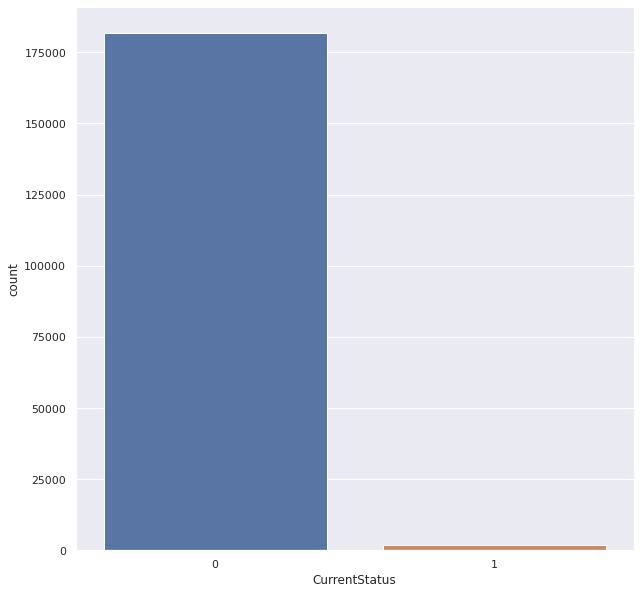

In [ ]:
sns.set(rc={'figure.figsize':(10,10)})
sns.countplot(x=target, data=df);

In [ ]:
df[target].value_counts() / df.shape[0]

0    0.990316
1    0.009684
Name: CurrentStatus, dtype: float64

just a sanity check

In [ ]:
set(num_cols+cat_cols + [target]) == set(df.columns)

True

## deal with missing values

In [ ]:
for i in df.columns:
    print(i)

PermitNumber
PermitType
PermitTypeDefinition
PermitCreationDate
Block
Lot
StreetNumber
StreetNumberSuffix
StreetName
StreetSuffix
Unit
UnitSuffix
Description
CurrentStatus
CurrentStatusDate
FiledDate
IssuedDate
CompletedDate
FirstConstructionDocumentDate
StructuralNotification
NumberofExistingStories
NumberofProposedStories
VoluntarySoft-StoryRetrofit
FireOnlyPermit
PermitExpirationDate
EstimatedCost
RevisedCost
ExistingUse
ExistingUnits
ProposedUse
ProposedUnits
Plansets
TIDFCompliance
ExistingConstructionType
ExistingConstructionTypeDescription
ProposedConstructionType
ProposedConstructionTypeDescription
SitePermit
SupervisorDistrict
Neighborhoods-AnalysisBoundaries
Zipcode
Location
RecordID


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 183713 entries, 1 to 198899
Data columns (total 43 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   PermitNumber                         183713 non-null  object 
 1   PermitType                           183713 non-null  int64  
 2   PermitTypeDefinition                 183713 non-null  object 
 3   PermitCreationDate                   183713 non-null  object 
 4   Block                                183713 non-null  object 
 5   Lot                                  183713 non-null  object 
 6   StreetNumber                         183713 non-null  int64  
 7   StreetNumberSuffix                   1992 non-null    object 
 8   StreetName                           183713 non-null  object 
 9   StreetSuffix                         181131 non-null  object 
 10  Unit                                 27280 non-null   float64
 11  UnitSuffix   

In [ ]:
df['EstimatedCost'].count()

146648

In [ ]:
list_to_drop = []
for col in num_cols + cat_cols + [target]:
    if df[col].count() < 130000:
        list_to_drop.append(col)
df2 = df.drop(list_to_drop, axis=1)

In [ ]:
df2[df2['CurrentStatus'] == 1].shape

(1779, 34)

In [ ]:
df2[df2['CurrentStatus'] == 0].count()

PermitNumber                           181934
PermitType                             181934
PermitTypeDefinition                   181934
PermitCreationDate                     181934
Block                                  181934
Lot                                    181934
StreetNumber                           181934
StreetName                             181934
StreetSuffix                           179360
Description                            181849
CurrentStatus                          181934
CurrentStatusDate                      181934
FiledDate                              181934
IssuedDate                             181153
FirstConstructionDocumentDate          181131
NumberofExistingStories                141161
NumberofProposedStories                141118
PermitExpirationDate                   144216
EstimatedCost                          144884
RevisedCost                            181880
ExistingUse                            142717
ExistingUnits                     

In [ ]:
df2[df2[target] == 1].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1779 entries, 90 to 197604
Data columns (total 34 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   PermitNumber                         1779 non-null   object 
 1   PermitType                           1779 non-null   int64  
 2   PermitTypeDefinition                 1779 non-null   object 
 3   PermitCreationDate                   1779 non-null   object 
 4   Block                                1779 non-null   object 
 5   Lot                                  1779 non-null   object 
 6   StreetNumber                         1779 non-null   int64  
 7   StreetName                           1779 non-null   object 
 8   StreetSuffix                         1771 non-null   object 
 9   Description                          1775 non-null   object 
 10  CurrentStatus                        1779 non-null   int64  
 11  CurrentStatusDate          

In [ ]:
df2[df3[target] == 0].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 181934 entries, 1 to 198899
Data columns (total 34 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   PermitNumber                         181934 non-null  object 
 1   PermitType                           181934 non-null  int64  
 2   PermitTypeDefinition                 181934 non-null  object 
 3   PermitCreationDate                   181934 non-null  object 
 4   Block                                181934 non-null  object 
 5   Lot                                  181934 non-null  object 
 6   StreetNumber                         181934 non-null  int64  
 7   StreetName                           181934 non-null  object 
 8   StreetSuffix                         179360 non-null  object 
 9   Description                          181849 non-null  object 
 10  CurrentStatus                        181934 non-null  int64  
 11  CurrentStatus

In [ ]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 183713 entries, 1 to 198899
Data columns (total 34 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   PermitNumber                         183713 non-null  object 
 1   PermitType                           183713 non-null  int64  
 2   PermitTypeDefinition                 183713 non-null  object 
 3   PermitCreationDate                   183713 non-null  object 
 4   Block                                183713 non-null  object 
 5   Lot                                  183713 non-null  object 
 6   StreetNumber                         183713 non-null  int64  
 7   StreetName                           183713 non-null  object 
 8   StreetSuffix                         181131 non-null  object 
 9   Description                          183624 non-null  object 
 10  CurrentStatus                        183713 non-null  int64  
 11  CurrentStatus

In [ ]:
df3 = df2.drop(['PermitNumber', 'PermitType', 'StreetSuffix', 'PermitExpirationDate', 'ExistingConstructionType', 'ProposedConstructionType', 'Zipcode', 'Location', 'RecordID'], axis=1)

In [ ]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 183713 entries, 1 to 198899
Data columns (total 25 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   PermitTypeDefinition                 183713 non-null  object 
 1   PermitCreationDate                   183713 non-null  object 
 2   Block                                183713 non-null  object 
 3   Lot                                  183713 non-null  object 
 4   StreetNumber                         183713 non-null  int64  
 5   StreetName                           183713 non-null  object 
 6   Description                          183624 non-null  object 
 7   CurrentStatus                        183713 non-null  int64  
 8   CurrentStatusDate                    183713 non-null  object 
 9   FiledDate                            183713 non-null  object 
 10  IssuedDate                           182589 non-null  object 
 11  FirstConstruc

In [ ]:
num_cols3 = [col for col in df3.columns if "int" in str(df3[col].dtype) or "float" in str(df3[col].dtype)]
cat_cols3 = [col for col in df3.columns if "object" == str(df3[col].dtype) and col != "CurrentStatus"]
print(num_cols3)
print(cat_cols3)

['StreetNumber', 'CurrentStatus', 'NumberofExistingStories', 'NumberofProposedStories', 'EstimatedCost', 'RevisedCost', 'ExistingUnits', 'ProposedUnits', 'Plansets', 'SupervisorDistrict']
['PermitTypeDefinition', 'PermitCreationDate', 'Block', 'Lot', 'StreetName', 'Description', 'CurrentStatusDate', 'FiledDate', 'IssuedDate', 'FirstConstructionDocumentDate', 'ExistingUse', 'ProposedUse', 'ExistingConstructionTypeDescription', 'ProposedConstructionTypeDescription', 'Neighborhoods-AnalysisBoundaries']


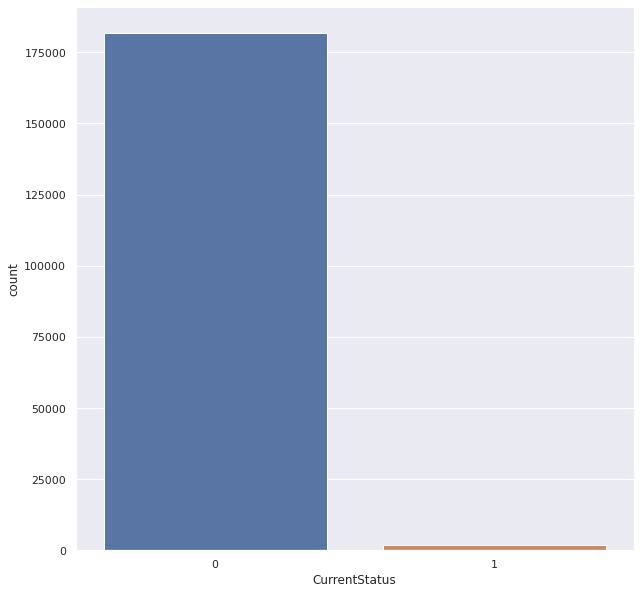

In [ ]:
sns.set(rc={'figure.figsize':(10,10)})
sns.countplot(x=target, data=df3);

In [ ]:
df3[target].value_counts() / df3.shape[0]

0    0.990316
1    0.009684
Name: CurrentStatus, dtype: float64

In [ ]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 183713 entries, 1 to 198899
Data columns (total 25 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   PermitTypeDefinition                 183713 non-null  object 
 1   PermitCreationDate                   183713 non-null  object 
 2   Block                                183713 non-null  object 
 3   Lot                                  183713 non-null  object 
 4   StreetNumber                         183713 non-null  int64  
 5   StreetName                           183713 non-null  object 
 6   Description                          183624 non-null  object 
 7   CurrentStatus                        183713 non-null  int64  
 8   CurrentStatusDate                    183713 non-null  object 
 9   FiledDate                            183713 non-null  object 
 10  IssuedDate                           182589 non-null  object 
 11  FirstConstruc

In [ ]:
df3.head()

,PermitTypeDefinition,PermitCreationDate,Block,Lot,StreetNumber,StreetName,Description,CurrentStatus,CurrentStatusDate,FiledDate,IssuedDate,FirstConstructionDocumentDate,NumberofExistingStories,NumberofProposedStories,EstimatedCost,RevisedCost,ExistingUse,ExistingUnits,ProposedUse,ProposedUnits,Plansets,ExistingConstructionTypeDescription,ProposedConstructionTypeDescription,SupervisorDistrict,Neighborhoods-AnalysisBoundaries
1,sign - erect,04/19/2016,0306,007,440,Geary,remove (e) awning and associated signs.,0,08/03/2017,04/19/2016,08/03/2017,08/03/2017,7.0,NaN,1.0,500.0,tourist hotel/motel,NaN,NaN,NaN,2.0,constr type 3,NaN,3.0,Tenderloin
3,otc alterations permit,11/07/2016,0156,011,1230,Pacific,repair dryrot & stucco at front of bldg.,0,07/24/2017,11/07/2016,07/18/2017,07/18/2017,2.0,2.0,2000.0,2000.0,1 family dwelling,1.0,1 family dwelling,1.0,2.0,wood frame (5),wood frame (5),3.0,Nob Hill
4,demolitions,11/28/2016,0342,001,950,Market,demolish retail/office/commercial 3-story buil...,0,12/01/2017,11/28/2016,12/01/2017,11/20/2017,3.0,NaN,100000.0,100000.0,retail sales,NaN,NaN,NaN,2.0,constr type 3,NaN,6.0,Tenderloin
5,otc alterations permit,06/14/2017,4105,009,800,Indiana,evac maps,0,07/06/2017,06/14/2017,07/06/2017,07/06/2017,5.0,5.0,4000.0,4000.0,apartments,326.0,apartments,326.0,2.0,constr type 1,constr type 1,10.0,Potrero Hill
6,otc alterations permit,06/30/2017,1739,020,1291,11th,re-roofing,0,07/12/2017,06/30/2017,06/30/2017,06/30/2017,3.0,3.0,12000.0,12000.0,apartments,5.0,apartments,5.0,0.0,wood frame (5),wood frame (5),5.0,Inner Sunset


In [ ]:
df3['StreetNumber_int'] = df3.StreetNumber.astype('int64')

<Axes: xlabel='StreetNumber_int', ylabel='CurrentStatus'>

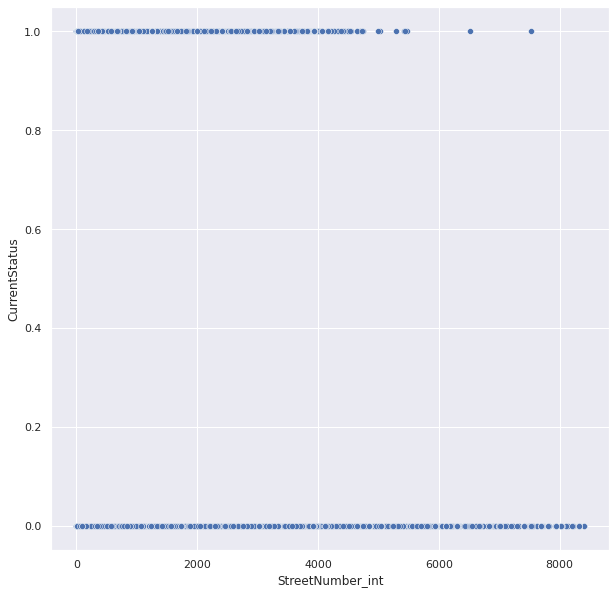

In [ ]:
sns.scatterplot(data=df3, x="StreetNumber_int", y=target)

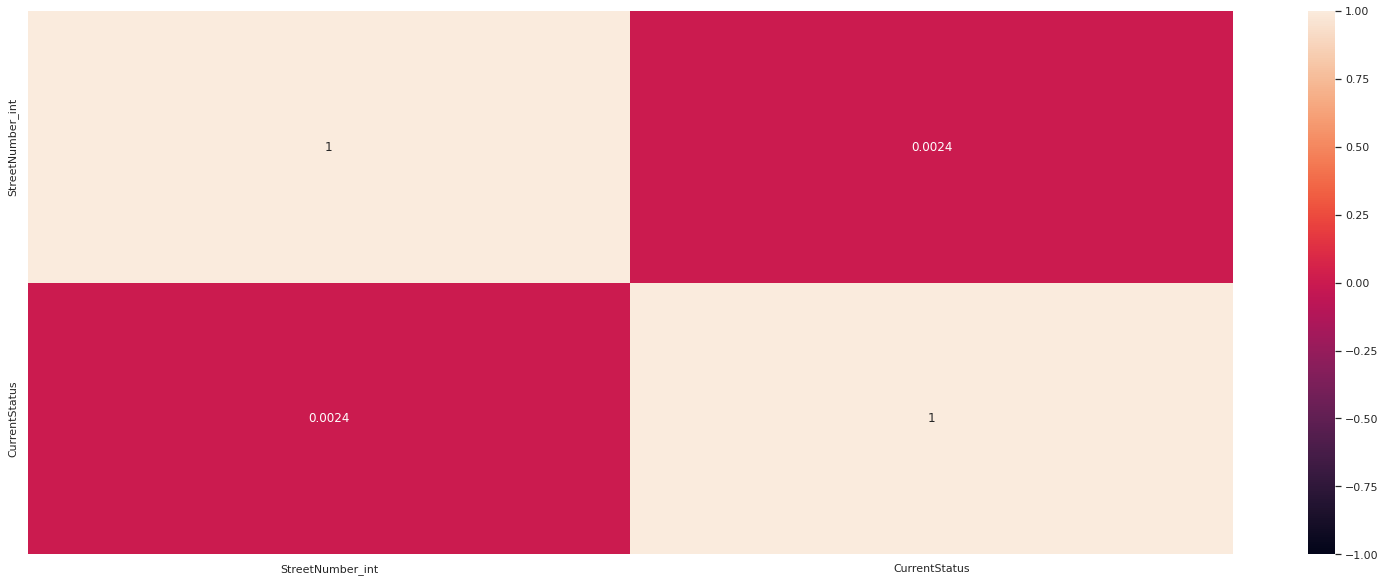

In [ ]:
sns.set(rc={'figure.figsize':(27,10)})

corr_matrix = df3[["StreetNumber_int"] + [target]].corr()
sns.heatmap(corr_matrix, vmin=-1, vmax=1, annot=True);

In [ ]:
columns_to_show1 = ['Block', 'Lot', 'StreetNumber', 'StreetName']
columns_to_show = ['StreetName']

df3.groupby([target])[columns_to_show].describe()

StreetName                      
                   count unique      top  freq
CurrentStatus                                 
0                 181934   1689   Market  5047
1                   1779    503  Mission    45

In [ ]:
df3.StreetName.unique()

array(['Geary', 'Pacific', 'Market', ..., 'Chain Of Lakes', 'Unknown',
       'Ignacio'], dtype=object)

In [ ]:
lst = []
for name in df3.StreetName.unique():
    cnts = list(df3[df3.StreetName == name][target].value_counts())
    #print(cnts)
    if len(cnts) == 1:
        if df3[df3.StreetName == name][target].unique()[0] == 0:
            lst.append((name, 0, cnts[0], 0))
        else:
            lst.append((name, 9999999, 0, cnts[0]))
    elif len(cnts) == 0: 
        lst.append((name, -1, 0, 0))
    else:    
        lst.append((name, cnts[1]/cnts[0], cnts[0], cnts[1]))

In [ ]:
lst.sort(key=(lambda x: x[1]), reverse=True)
lst

In [ ]:
lst[-50:-1]

In [ ]:
df3[df3[target] == 0].info()

In [ ]:
df3[df3[target] == 1].info()

In [ ]:
df3.drop_duplicates()

In [ ]:
df_without_nan_cols = df3.drop(['FirstConstructionDocumentDate'], axis=1)

In [ ]:
df_without_nan_cols.dropna(inplace=True)

In [ ]:
df_without_nan_cols.head()

,PermitTypeDefinition,PermitCreationDate,Block,Lot,StreetNumber,StreetName,Description,CurrentStatus,CurrentStatusDate,FiledDate,IssuedDate,NumberofExistingStories,NumberofProposedStories,EstimatedCost,RevisedCost,ExistingUse,ExistingUnits,ProposedUse,ProposedUnits,Plansets,ExistingConstructionTypeDescription,ProposedConstructionTypeDescription,SupervisorDistrict,Neighborhoods-AnalysisBoundaries,StreetNumber_int
3,otc alterations permit,11/07/2016,0156,011,1230,Pacific,repair dryrot & stucco at front of bldg.,0,07/24/2017,11/07/2016,07/18/2017,2.0,2.0,2000.0,2000.0,1 family dwelling,1.0,1 family dwelling,1.0,2.0,wood frame (5),wood frame (5),3.0,Nob Hill,1230
5,otc alterations permit,06/14/2017,4105,009,800,Indiana,evac maps,0,07/06/2017,06/14/2017,07/06/2017,5.0,5.0,4000.0,4000.0,apartments,326.0,apartments,326.0,2.0,constr type 1,constr type 1,10.0,Potrero Hill,800
6,otc alterations permit,06/30/2017,1739,020,1291,11th,re-roofing,0,07/12/2017,06/30/2017,06/30/2017,3.0,3.0,12000.0,12000.0,apartments,5.0,apartments,5.0,0.0,wood frame (5),wood frame (5),5.0,Inner Sunset,1291
24,otc alterations permit,08/08/2017,0542,039,1,Charlton,re-roofing,0,08/08/2017,08/08/2017,08/08/2017,4.0,4.0,64650.0,64650.0,apartments,9.0,apartments,9.0,0.0,wood frame (5),wood frame (5),2.0,Marina,1
25,otc alterations permit,08/16/2017,1824,006,1435,29th,re-roofing,0,08/16/2017,08/16/2017,08/16/2017,2.0,2.0,7000.0,7000.0,1 family dwelling,1.0,1 family dwelling,1.0,0.0,wood frame (5),wood frame (5),4.0,Sunset/Parkside,1435
